Will use **MNIST** dataset to train the encoder to learn a model extracting features like lines and curves from an image. Then will use the similarity between the encoded feature of the **given image** and  the **drawn and submitted image** via the application again will contribute to the MMSE score of a patient in the application.

In [12]:
import os
import cv2
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Scikit-learn functions
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [13]:
class MIDAS_CNN:
    def __init__(self):
        self.model = None

    # A function to define and compile the CNN
    def compile_CNN(self, MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR,
                    MOMENTUM=0.9, label_smoothing=0.1, og_model=None):
        '''
            MODEL_INPUT_SIZE: (CNN)model input size
            N_CLASSES: number of classes in the final layer
            INITIAL_LR: initial learning rate of the optimizer (optional)
            MOMENTUM: momentum of the SGD optimizer (optional)
            label_smoothing: learning rate of the optimizer (optional)
            og_model: original model to transfer learn from (optional)
        '''
        try:
            self.MODEL_INPUT_SIZE = MODEL_INPUT_SIZE
            self.N_CLASSES = N_CLASSES
            self.INITIAL_LR = INITIAL_LR

            if og_model is None:
                # Defining the model
                self.model = Sequential()  # add model layers
                # Layer 1
                self.model.add(Conv2D(8, (3, 3), input_shape=self.MODEL_INPUT_SIZE))
                # define the activaion function for this layer
                self.model.add(Activation('relu'))
                # define the pooling for this layer
                self.model.add(MaxPool2D(pool_size=(2, 2)))

                # Layer 2
                self.model.add(Conv2D(16, (3, 3)))
                # define the activaion function for this layer
                self.model.add(Activation('relu'))
                # define the pooling for this layer
                self.model.add(MaxPool2D(pool_size=(5, 5)))

                # Flattening
                self.model.add(Flatten())
                # Dropout
                self.model.add(Dropout(0.5, name='final_dropout'))  # - for regularization

                # Final output layer
                self.model.add(Dense(N_CLASSES, activation='softmax',
                                     name='classification', dtype='float32'))
                self.model.compile(optimizer=SGD(learning_rate=INITIAL_LR,
                                                 momentum=MOMENTUM, nesterov=True),
                                   loss=CategoricalCrossentropy(label_smoothing=label_smoothing),
                                   metrics=['accuracy'])
                self.model.summary()
                return None
            else:
                og_model.layers.pop()
                outputs = Dense(N_CLASSES, activation="softmax",
                                name="classification", dtype='float32')(og_model.layers[-2].output)
                self.model = Model(inputs=og_model.inputs, outputs=outputs)
                print('Original Model Transformed successfully')
                self.model.compile(optimizer=SGD(learning_rate=INITIAL_LR,
                                                 momentum=MOMENTUM, nesterov=True),
                                   loss=CategoricalCrossentropy(label_smoothing=label_smoothing),
                                   metrics=['accuracy'])
                self.model.summary()
                return None
        except:
            print('Error in compiling the CNN')
            return None

    # A function to define the data-generators
    def define_generators(self, BATCH_SIZE, df, x_col='imgs', y_col='label',
                          stratify=True, VALIDATION_SPLIT=0.1):
        '''
             BATCH_SIZE: batch size of the generators
             df: dataframw with all the images and labels
             x_col: name of the column with image name (optional)
             y_col: name of the column with the image label (optional)
             stratify: to make a stratified split (optional)
             VALIDATION_SPLIT: percentage of data to be used for validation (optinal)
        '''
        try:
            self.BATCH_SIZE = BATCH_SIZE
            self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]

            if stratify:

                df_train, df_validation = train_test_split(df, test_size=VALIDATION_SPLIT, random_state=2021,
                                                           stratify=df[y_col].values.tolist())
            else:
                df_train, df_validation = train_test_split(df, test_size=VALIDATION_SPLIT, random_state=2021)
            # Setting a seed to get the same split everytime

            # Augmenting the train generator
            data_generator = ImageDataGenerator(
                rotation_range=10,  # in degrees
                width_shift_range=0.05,  # <1 shift left or right
                height_shift_range=0.05,  # <1 shift up or down
                zoom_range=[0.9, 1.1],  # zooming range
                rescale=1. / 255,  # rescale the images to be float in range [0, 1]
            )

            self.train_generator = data_generator.flow_from_dataframe(
                dataframe=df_train,
                x_col=x_col,  # column with image path
                y_col=y_col,  # column with label
                target_size=self.INPUT_SIZE,
                batch_size=self.BATCH_SIZE,
                color_mode='grayscale',
                class_mode='categorical',
                shuffle=True,
                seed=2021,  # seeting the seed for shuffling and transformation
            )

            # Not augmenting the validation generator
            data_generator = ImageDataGenerator(
                rescale=1. / 255,  # rescale the images to be float in range [0, 1]
            )

            self.validation_generator = data_generator.flow_from_dataframe(
                dataframe=df_validation,
                x_col=x_col,  # column with image path
                y_col=y_col,  # column with label
                target_size=self.INPUT_SIZE,
                batch_size=self.BATCH_SIZE,
                color_mode='grayscale',
                class_mode='categorical',
                shuffle=False,
            )
            return None
        except:
            print('Error in defining generators')
            return None

    # A function to define the callbacks
    def define_callbacks(self, ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME,
                         LR_REDUCTION_FACTOR=0.2, MODEL_LOC='./models'):
        '''
            ES_PATIENCE: patience for early stopping
            LR_PATIENCE: patience to reduce learning-rate
            MODEL_WTS_FILE_NAME: weights .h5 filename
            LR_REDUCTION_FACTOR: factor to reduce the learning rate by (optinal)
            MODEL_LOC: location to save models in (optional)
        '''
        try:
            if not os.path.exists(MODEL_LOC):
                os.mkdir(MODEL_LOC)
            # Defining callbacks
            self.MODEL_LOC = MODEL_LOC
            self.MODEL_WTS_FILE_NAME = MODEL_WTS_FILE_NAME
            es_callback = EarlyStopping(
                monitor='val_accuracy',
                patience=ES_PATIENCE,
                mode='max'
            )  # only stopping if model's validation accuracy has saturated/peaked

            reduce_lr_callback = ReduceLROnPlateau(
                monitor='val_loss',
                patience=LR_PATIENCE, verbose=1,
                factor=LR_REDUCTION_FACTOR
            )  # reducing learning rate if validation loss doesn't deacrease

            mc_callback = ModelCheckpoint(
                filepath=os.path.join(self.MODEL_LOC, self.MODEL_WTS_FILE_NAME),
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )  # saving the best model based on accuracy on validation dataset

            # Defining callbacks for saving model checkpoints and early stopping
            self.callbacks = [es_callback, mc_callback, reduce_lr_callback]
            return None
        except:
            print('Error in defining callbacks')
            return None

    # A function to train the defined model
    def train(self, EPOCHS=100):
        '''
            EPOCHS: epochs to train the model for
        '''
        try:
            self.train_history = self.model.fit(
                self.train_generator,
                steps_per_epoch=self.train_generator.samples // self.BATCH_SIZE,
                validation_data=self.validation_generator,
                validation_steps=self.validation_generator.samples // self.BATCH_SIZE,
                epochs=EPOCHS, verbose=1, callbacks=self.callbacks
            )
            return None
        except:
            print('Error in training model')
            return None

    # A function to train given X and Y for MNIST
    def train_x_y(self, x_train, y_train,
                  BATCH_SIZE, EPOCHS, VALIDATION_SPLIT):
        '''
            x_train: training data
            y_train: testing data
            BATCH_SIZE: batch size for training and validation
            EPOCHS: epochs for training
            VALIDATION_SPLIT: percentage of data to be used for validation
        '''
        try:
            self.BATCH_SIZE = BATCH_SIZE
            self.train_history = self.model.fit(
                x_train, y_train,
                batch_size=self.BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=VALIDATION_SPLIT,
                callbacks=self.callbacks
            )
            return None
        except:
            print('Error in training model')
            return None

    # A function to plot training history
    def training_history(self, title='training history'):
        '''
            title: title of the plot (optional)
        '''
        try:
            fig = plt.figure(1, figsize=(15, 7))
            axes = fig.add_subplot(1, 2, 1)
            axes.plot(self.train_history.history['accuracy'], color='C0')
            axes.plot(self.train_history.history['val_accuracy'], color='C1')
            axes.set(xlabel='Epochs', ylabel='Accuracy', title='Model Accuracy')
            axes.legend(['train accuracy', 'validation accuracy'])

            axes = fig.add_subplot(1, 2, 2)
            axes.plot(self.train_history.history['loss'], color='C0')
            axes.plot(self.train_history.history['val_loss'], color='C1')
            axes.set(xlabel='Epochs', ylabel='Loss', title='Model Loss')
            axes.legend(['train loss', 'validation loss'])
            plt.suptitle('MIDAS CNN - OG(scratch) training history')
            plt.show()
            return None
        except:
            print('Error in plotting history of the model')
            return None

    # A function plot confusion matrix
    def analyze_model(self, figsize=(10, 7)):
        '''
            figuresize: size of plot (optional)
        '''
        try:
            probabilities = self.model.predict(self.validation_generator, len(self.validation_generator))
            prediction_label = np.argmax(probabilities, axis=1)
            val_labels = self.validation_generator.classes

            print('Class labels')
            print(self.validation_generator.class_indices)
            print('\n')

            print('Class distribution in validation set')
            n_class, n_count = np.unique(val_labels, return_counts=True)
            count_dict = {}
            for n_class_, n_count_ in zip(n_class, n_count):
                count_dict[n_class_] = n_count_
            print(f'{count_dict}')
            print('\n')

            classes = self.validation_generator.class_indices.keys()
            # Plotting confusion matrix
            cm = confusion_matrix(prediction_label, val_labels)
            df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
            fig, ax = plt.subplots(figsize=figsize)  # Sample figsize in inches
            sns.heatmap(df_cm, annot=True, ax=ax)
            plt.xlabel('True Labels')
            plt.ylabel('Predicted Labels')
            plt.title('Validation Confusion Matrix')
            acc = ((prediction_label == val_labels).sum()) / len(val_labels) * 100
            print('Validation Accuracy of the model is %.2f%%' % (acc))
            plt.show()
            return None
        except:
            print('Error in analyzing the model')
            return None

    # A function to make test prediction and plot confusion matrix
    def analyse_x_y(self, x_test, y_test, figsize=(10, 7)):
        '''
            x_test: test data
            y_test: test label
            figsize: size of the plot (optional)
        '''
        try:
            probabilities = self.model.predict(x_test)
            prediction_label = np.argmax(probabilities, axis=1)
            val_labels = np.argmax(y_test, axis=1)

            print('Class distribution in MNIST test set')
            n_class, n_count = np.unique(val_labels, return_counts=True)
            count_dict = {}
            for n_class_, n_count_ in zip(n_class, n_count):
                count_dict[n_class_] = n_count_
            print(f'{count_dict}')
            print('\n')

            classes = np.unique(val_labels)
            classes.sort()
            # Plotting confusion matrix
            cm = confusion_matrix(prediction_label, val_labels)
            df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
            fig, ax = plt.subplots(figsize=figsize)  # Sample figsize in inches
            sns.heatmap(df_cm, annot=True, ax=ax)
            plt.xlabel('True Labels')
            plt.ylabel('Predicted Labels')
            plt.title('Test Confusion Matrix')
            acc = ((prediction_label == val_labels).sum()) / len(val_labels) * 100
            print('Test Accuracy of the model is %.2f%%' % (acc))
            plt.show()
        except:
            print('Error in analyzing the model')
            return None

    # A function to return the trained model
    def return_model(self):
        return self.model

    # A function to return training history
    def return_training_history(self):
        return self.train_history

    # A function to load the trained model
    def load_model(self, model_loc=None):
        '''
            model_loc: location of the .h5 file to load weights from
        '''
        try:
            if model_loc is not None:
                self.model.load_weights(model_loc)
            else:
                self.model.load_weights(os.path.join(self.MODEL_LOC, self.MODEL_WTS_FILE_NAME))
            return None
        except:
            print('Error in loading weights for the model')
            return None

    # A function to make prediction
    def predict_img(self, img_loc):
        '''
        INPUT ->
            img_loc: Takes in location of an image
        OUTPUT ->
            prediction-probabilit, prediction-label
        '''
        self.img_sz = self.MODEL_INPUT_SIZE[0]
        try:
            if os.path.exists(img_loc):
                try:
                    img = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
                    # rescaling image
                    img = cv2.resize(img, dsize=(self.img_sz, self.img_sz),
                                     interpolation=cv2.INTER_AREA)
                    plt.imshow(img)
                    img = img / 255
                    img = img.reshape(1, self.img_sz, self.img_sz, 1)
                except:
                    print('Unable to load image')
                    return None, None
                # load the model before calling this function

                print(np.shape(img))
                prediction_prob = self.model.predict(img)
                prediction_label = np.argmax(prediction_prob, axis=1)
                return prediction_prob[0], prediction_label[0]
            else:
                print(f'No image found with path {img_loc}.')
                return None, None
        except:
            print('Error in predicting for an image')
            return None, None

    # A function to define a batch for data-format
    # similar to the training data for testing
    def test_format1(self, test_data_loc, BATCH_SIZE=16):
        self.BATCH_SIZE = BATCH_SIZE
        self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]
        # Not augmenting the test generator
        data_generator = ImageDataGenerator(
            rescale=1. / 255,  # rescale the images to be float in range [0, 1]
        )
        test_generator = data_generator.flow_from_directory(
            directory=test_data_loc,
            target_size=self.INPUT_SIZE,
            batch_size=self.BATCH_SIZE,
            color_mode='grayscale',
            class_mode='categorical',
            shuffle=False,
        )

        # Predict in the test-data make sure that you have loaded the model
        prediction_probs = self.model.predict_generator(test_generator)
        prediction_labels = np.argmax(prediction_probs, axis=1)
        test_labels = test_generator.classes
        
        print('Class labels')
        print(test_generator.class_indices)
        classes = test_generator.class_indices.keys()
        print('\n')
        # Plotting confusion matrix
        acc = self.analyse_test_set(prediction_labels, test_labels, classes)
        return acc
        
        
    #  A function to define a batch for data-format
    # similar to kaggle to generate predictions.csv
    def test_format2(self, test_data_loc, BATCH_SIZE=16):
        self.BATCH_SIZE = BATCH_SIZE
        self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]
        images = os.listdir(test_data_loc)
        df = pd.DataFrame()
        df['image'] = images
        df['dummy_class'] = ['' for image in images]
        data_generator = ImageDataGenerator(
            rescale=1. / 255,  # rescale the images to be float in range [0, 1]
        )
        test_generator = data_generator.flow_from_dataframe(
            df,
            directory=test_data_loc,
            x_col='image',
            y_col='dummy_class',
            target_size = self.INPUT_SIZE,
            batch_size = self.BATCH_SIZE,
            color_mode = 'grayscale',
            class_mode = None,
            shuffle = False,
        )
        prediction_probs = self.model.predict_generator(test_generator)
        prediction_labels = np.argmax(prediction_probs, axis=1)
        df.drop(['image', 'dummy_class'], axis=1)
        df['image'] = list(test_generator.filenames)
        df['probability'] = list(prediction_probs)
        df['label'] = list(prediction_labels)
        return df

    def analyse_test_set(self, predictions, labels, classes):
        # Plotting confusion matrix
        cm = confusion_matrix(predictions, labels)
        df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
        plt.figure(figsize=(20, 15))
        plt.title('Test Confusion Matrix')
        sns.heatmap(df_cm, annot=True)
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')

        acc = ((predictions == labels).sum()) / len(labels) * 100
        print('Test Accuracy of the model is %.2f%%' % (acc))
        plt.show()
        return acc

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

Defining and compiling model-1 for training

#### Defining the model & generators (to load the images in batches for training)

First defining some basic parameters and then defining a small model with less number of parametrs because theoretically, a simple two-layer neural network with **2n+d parameters** is capable of perfectly fitting any dataset of **n samples** of **dimension d** ([Zhang et al., 2017](https://arxiv.org/abs/1611.03530)). So to answer your question, having such a large model can lead to overfitting. 

We have **~2000** samples to learn from (after using `10%` of `2480 data-points` for validation). So our **n is 2232** and our **d is 28$\times$28 = 784** *(input-size)*, thus to be able to not overfit and train a model from scratch we should have **< 5248(~5000)** parameters in the network which will needs to be a small network which fairly less number of features in the `flat layer`. If we want to define more layers then we must add regularization of some sort to avoide overfitting (since this number of allowed parameters to avoide overfitting is way too less I will use **Dropout** regularization). In addition I will have some data-augmentations to generate artificical (sudo) data-points, these factors will allow me to have parameters in CNN and still avoide overfitting.

Adding higher label-smmothing (default label-smmothing 0.1 for MIDAS-CNN) to the model-loss because of the possibel confusion that can occur in this dataset.


Training the model on MNIST dataset and then using this model.

In [14]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-2-a.h5'
ES_PATIENCE = 30 # patience for early-stopping (in epochs)
'''
using a high early stopping crierion as the model is trained
from scratch and we do not want it to stop early
'''
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

Training on MNIST dataset and analysing its result.

In [15]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-2-b.h5'
ES_PATIENCE = 10 # patience for early-stopping (in epochs)
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

In [16]:
task2b_CNN = MIDAS_CNN()
task2b_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 activation_4 (Activation)   (None, 26, 26, 8)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 activation_5 (Activation)   (None, 11, 11, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                  

#### Loading the MNIST data-set

MNIST data is one of the data-sets avaialable in keras and we can directly download and load it from there.

Loading training and testing MNIST data for its standard split

In [17]:
# We can directly load the MNIST dataset in keras 
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

####-----REF - https://keras.io/examples/vision/mnist_convnet/ -----####
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

#### Training the model

In [18]:
# Training the model on the MNIST dataset

#Defining callbacks
task2b_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
# Loading the weights of task2a model in task2b for transfer-learning
task2b_CNN.load_model(os.path.join(MODEL_LOC, 'CNN-subtask-2-a.h5'))
# Training the model
task2b_CNN.train_x_y(x_train, y_train, BATCH_SIZE, EPOCHS, VALIDATION_SPLIT)

Error in loading weights for the model
Epoch 1/100
1688/1688 [==============================] - 25s 14ms/step - loss: 1.2600 - accuracy: 0.6952 - val_loss: 0.7160 - val_accuracy: 0.9593 - lr: 0.0100
Epoch 2/100
1688/1688 [==============================] - 23s 13ms/step - loss: 0.9621 - accuracy: 0.8453 - val_loss: 0.6867 - val_accuracy: 0.9668 - lr: 0.0100
Epoch 3/100
1688/1688 [==============================] - 23s 13ms/step - loss: 0.9224 - accuracy: 0.8659 - val_loss: 0.6667 - val_accuracy: 0.9697 - lr: 0.0100
Epoch 4/100
1688/1688 [==============================] - 23s 14ms/step - loss: 0.9054 - accuracy: 0.8733 - val_loss: 0.6604 - val_accuracy: 0.9722 - lr: 0.0100
Epoch 5/100
1688/1688 [==============================] - 23s 14ms/step - loss: 0.8949 - accuracy: 0.8774 - val_loss: 0.6595 - val_accuracy: 0.9743 - lr: 0.0100
Epoch 6/100
1688/1688 [==============================] - 23s 14ms/step - loss: 0.8850 - accuracy: 0.8813 - val_loss: 0.6534 - val_accuracy: 0.9757 - lr: 0.0100
E

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

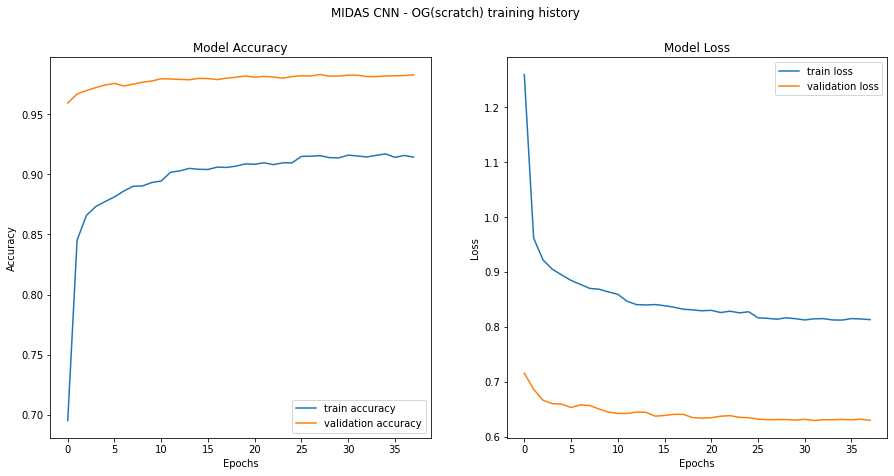

In [19]:
task2b_CNN.training_history(title='MIDAS CNN - MNIST(TL) training history')

#### Visualizing the test performance of the model

Visualizing the model's performance on the MNIST test-set.

Class distribution in MNIST test set
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Test Accuracy of the model is 97.88%


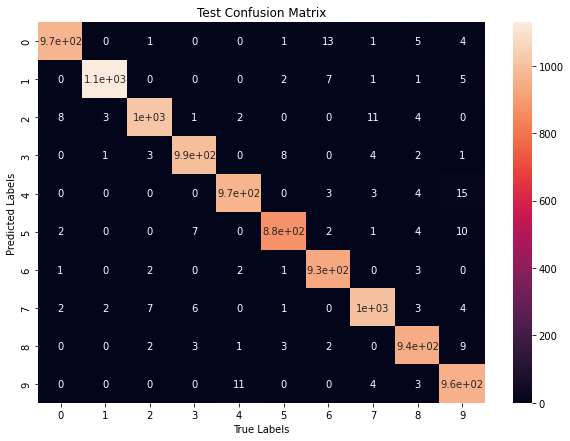

In [20]:
task2b_CNN.load_model()
task2b_CNN.analyse_x_y(x_test, y_test)

Using the encoder of the model to identify how good the pattern that patients in the app are submitting is to the actual drawing.

In [21]:
model = task2b_CNN.return_model()
print(model.layers)

[<keras.layers.convolutional.Conv2D object at 0x7f482ad0c050>, <keras.layers.core.activation.Activation object at 0x7f48288fa9d0>, <keras.layers.pooling.MaxPooling2D object at 0x7f48288fadd0>, <keras.layers.convolutional.Conv2D object at 0x7f48288faf10>, <keras.layers.core.activation.Activation object at 0x7f482882a210>, <keras.layers.pooling.MaxPooling2D object at 0x7f482b7c0990>, <keras.layers.core.flatten.Flatten object at 0x7f48288a4d10>, <keras.layers.core.dropout.Dropout object at 0x7f48288ef590>, <keras.layers.core.dense.Dense object at 0x7f482ad1f890>]


Getting output from layer.

In [26]:
# selecting the last third layer of the model
layer = model.layers[-3]
intermediate_layer_model = Model(inputs=model.input, outputs=layer.output)

In [28]:
def encode_input(img_loc, model):
  img_sz = 28
  img = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
  # rescaling image
  img = cv2.resize(img, dsize=(img_sz, img_sz),
                   interpolation=cv2.INTER_AREA)
  img = img / 255
  img = img.reshape(1, img_sz, img_sz, 1)
  encoded_features = model.predict(img)
  return encoded_features

In [29]:
# prepare the input for the model
imgs = ['pattern.jpg', 'draw-1.jpg', 'draw-2.jpg', 'draw-3.jpg']
features = []

for img in imgs:
  features.append(encode_input(img_loc=img, model=intermediate_layer_model))

In [37]:
from scipy import spatial

similarities = []
for feature in features[1:]:
  similarities.append(1- spatial.distance.cosine(features[0], feature))

In [44]:
similarities

[0.9236742258071899, 0.9318970441818237, 0.9780328869819641]

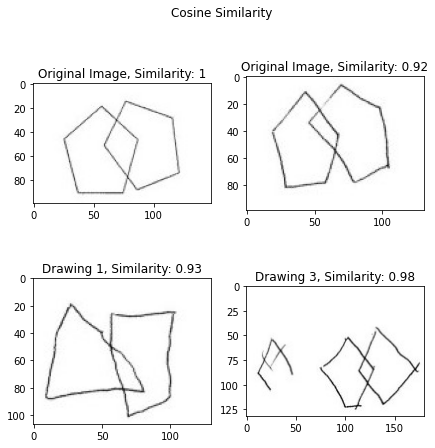

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
ax[0][0].imshow(cv2.imread(imgs[0]))
ax[0][0].set_title(f'Original Image, Similarity: 1')

ax[0][1].imshow(cv2.imread(imgs[1]))
ax[0][1].set_title(f'Original Image, Similarity: {round(similarities[0], 2)}')

ax[1][0].imshow(cv2.imread(imgs[2]))
ax[1][0].set_title(f'Drawing 1, Similarity: {round(similarities[1], 2)}')

ax[1][1].imshow(cv2.imread(imgs[3]))
ax[1][1].set_title(f'Drawing 3, Similarity: {round(similarities[2], 2)}')

plt.suptitle('Cosine Similarity')
plt.show()